In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from energydiagram import ED # https://github.com/giacomomarchioro/PyEnergyDiagrams

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

### some constants

In [2]:
EPSILON = 1e-10
DECIMALS = int(-1*np.log10(EPSILON))

a = 0
aN = 1.47
aO = 1.18

b = 1
bCN = 1.3
bCO = 1.93

### Hueckel matrices for selected compounds

In [3]:
def linearPolyene(n):
    if n % 2:
        print("Remember: uneven carbon numbers give radicals!")
        
    mat = b * (np.eye(n, k=1) + np.eye(n, k=-1))
    np.fill_diagonal(mat, a)     
    return mat


def cyclicPolyene(n):
    if n % 2:
        print("Remember: uneven carbon numbers give radicals!")
        
    mat = b * (np.eye(n, k=1) + np.eye(n, k=-1))
    np.fill_diagonal(mat, a)
    mat[0][n-1] = mat[n-1][0] = b
    return mat


allylradical = np.array([
    [a, b, 0],
    [b, a, b],
    [0, b, a]
])

methylidenecyclopropene = np.array([
    [a, b, 0, 0],
    [b, a, b, b],
    [0, b, a, b],
    [0, b, b, a]
])

benzaldehyde = np.array([
    [a,   b, 0, 0, 0, b, 0,   0,   bCN],
    [b,   a, b, 0, 0, 0, 0,   0,   0],
    [0,   b, a, b, 0, 0, 0,   0,   0],
    [0,   0, b, a, b, 0, 0,   0,   0],
    [0,   0, 0, b, a, b, 0,   0,   0],
    [a,   0, 0, 0, b, a, b,   0,   0],
    [0,   0, 0, 0, 0, b, a,   bCO, 0],
    [0,   0, 0, 0, 0, 0, bCO, aO,  0],
    [bCN, 0, 0, 0, 0, 0, 0,   0,   aN]
])

trimethylenmethane_dication = np.array([
    [a, b, 0, 0],
    [b, a, b, b],
    [0, b, a, 0],
    [0, b, 0, a]
])

In [4]:
def solve(mat, charge = 0):
    # use eigh to solve matrix eigenvalue problem since Hueckel matrix is always symmetric
    # eVals: the eigenvalues in ascending order, each repeated according to its multiplicity.
    # eVecs: the column v[:, i] is the normalized eigenvector corresponding to the eigenvalue w[i].
    eVals, eVecs = np.linalg.eigh(mat)

    # round so that we can test for degeneracy later and resubstitute e = a - x * b
    energies = np.around(np.subtract(a, eVals) * b, decimals=DECIMALS)
    eigenVectors = np.around(eVecs, decimals=DECIMALS)
    
    # flip both arrays to have them sorted in order of increasing energy again
    energies = energies[::-1]
    eigenVectors = np.fliplr(eigenVectors)
    
    # calculate some properties
    size = mat.shape[0]
    occupation = getOccupation(size, charge)
    P = getDensityMatrix(eigenVectors, occupation)
    E = getPiElectronEnergy(energies, occupation)
    Ed = getDelocalizationEnergy(energies, occupation)
    
    return energies, eigenVectors, P, E, Ed, occupation


def getOccupation(size, charge):
    # number of electrons is equal to dimension of Hueckel matrix (minus a possible charge) 
    electrons = size - charge
    occupation = np.zeros(size, dtype=int)
    
    # add to index of occupation array until it has 2 electrons
    idx = 0
    for i in range(electrons):
        if occupation[idx] == 2:
            idx += 1
        occupation[idx] += 1

    return occupation


def getDensityMatrix(eigenVectors, occupation):
    size = len(occupation)
    P = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            for k in range(len(occupation)):
                P[i][j] += occupation[k] * eigenVectors[i, k] * eigenVectors[j, k]
    
    return P


def getPiElectronEnergy(energies, occupation):
    return sum(occupation[i] * energies[i] for i in range(len(occupation)))


def getDelocalizationEnergy(energies, occupation):
    # only valid for hydrocarbons, i.e. a = 0 and b = 1
    e = getPiElectronEnergy(energies, occupation)
    return e + sum(occupation)


def plotResults(energies, eigenVectors, occupation):
    print("\n\nMO scheme (occupation = {}):".format(occupation))
    diagram = ED()

    for idx, e in enumerate(energies):
        e = round(e, 3)
        
        # convert eigenvector for printing to string
        if len(eigenVectors) > 5:
            half = int(np.around(len(eigenVectors) * 0.5, 1))
            coeffs1 = np.array2string(eigenVectors[:half, idx])
            coeffs2 = np.array2string(eigenVectors[half:, idx])
            coeffs = "\n".join([coeffs1, coeffs2])
        else:
            coeffs = np.array2string(eigenVectors[:, idx])

        # put degenerate orbitals on same height
        if idx == 0:
            previousEnergy = False
        else:
            previousEnergy = energies[idx - 1]
        
        if previousEnergy == e:
            diagram.add_level(e, coeffs, 2)
        else:
            diagram.add_level(e, coeffs, 1)        
        
    diagram.plot(show_IDs=True, ylabel="energy")


def printResults(energies, eigenVectors, E, Ed):
    print("Eigenvalues and corresponding eigenvectors in ascending order (lowest energy first):")
    for i, e in enumerate(energies):
        vector = eigenVectors[:, i]
        nodes = len(list(itertools.groupby(vector, lambda x: x > 0))) - 1   
        print("e{} = {: .2F}\teigenvector: {} -> {} nodes".format(i, round(e, 3), vector, nodes))
    
    print("\npi electron energy = {: .2F}".format(E))
    print("(total energy of pi electron system within Hueckel formalism)")
    print("\ndelocalization energy = {: .2F}".format(Ed))
    print("(difference between pi electron energy of molecule with delocalized pi-bonds and")
    print("pi electron energy of hypothetical pendant with strictly localized bonds)")


def printMatrices(hueckel, P):
    l = hueckel.shape[0]
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    ax[0].set_xticks(np.arange(0, l))
    ax[0].set_xticklabels(np.linspace(1, l+1, l+1))
    ax[0].set_yticks(np.arange(0, l))
    ax[0].set_yticklabels(np.linspace(1, l+1, l+1))
    ax[0].imshow(hueckel, origin="upper")
    ax[0].set_title("Hueckel matrix {}".format(hueckel.shape))
    ax[0].xaxis.tick_top()
    for (j, i), label in np.ndenumerate(hueckel):
        ax[0].text(i, j, label, ha='center', va='center')
    
    ax[1].set_xticks(np.arange(0, l))
    ax[1].set_xticklabels(np.linspace(1, l+1, l+1))
    ax[1].set_yticks(np.arange(0, l))
    ax[1].set_yticklabels(np.linspace(1, l+1, l+1))
    ax[1].imshow(P, origin="upper")
    ax[1].set_title("density matrix {}:".format(P.shape))
    ax[1].xaxis.tick_top()
    for (j, i), label in np.ndenumerate(P):
        ax[1].text(i, j, round(label, 3), ha='center', va='center')
    plt.show()
    
    print("")
    

def fullRoutine(mat, charge = 0):
    # get eigenvals and eigenvectors
    energies, eigenVectors, P, E, Ed, o = solve(hueckelMatrix, charge)
    
    # show results
    printMatrices(hueckelMatrix, P)
    printResults(energies, eigenVectors, E, Ed)
    plotResults(energies, eigenVectors, o)   

# example 1: Ethylene

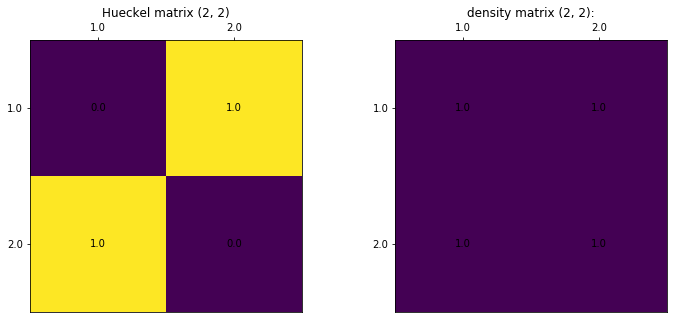


Eigenvalues and corresponding eigenvectors in ascending order (lowest energy first):
e0 = -1.00	eigenvector: [ 0.707  0.707] -> 0 nodes
e1 =  1.00	eigenvector: [-0.707  0.707] -> 1 nodes

pi electron energy = -2.00
(total energy of pi electron system within Hueckel formalism)

delocalization energy =  0.00
(difference between pi electron energy of molecule with delocalized pi-bonds and
pi electron energy of hypothetical pendant with strictly localized bonds)


MO scheme (occupation = [2 0]):


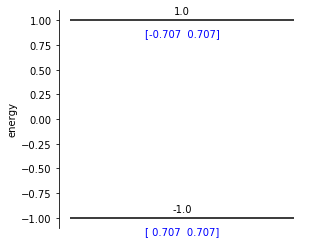

In [5]:
hueckelMatrix = linearPolyene(2)
fullRoutine(hueckelMatrix)

# example 2: Butadiene

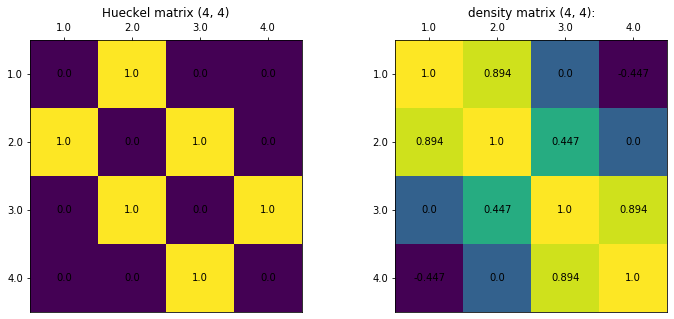


Eigenvalues and corresponding eigenvectors in ascending order (lowest energy first):
e0 = -1.62	eigenvector: [ 0.372  0.602  0.602  0.372] -> 0 nodes
e1 = -0.62	eigenvector: [-0.602 -0.372  0.372  0.602] -> 1 nodes
e2 =  0.62	eigenvector: [-0.602  0.372  0.372 -0.602] -> 2 nodes
e3 =  1.62	eigenvector: [ 0.372 -0.602  0.602 -0.372] -> 3 nodes

pi electron energy = -4.47
(total energy of pi electron system within Hueckel formalism)

delocalization energy = -0.47
(difference between pi electron energy of molecule with delocalized pi-bonds and
pi electron energy of hypothetical pendant with strictly localized bonds)


MO scheme (occupation = [2 2 0 0]):


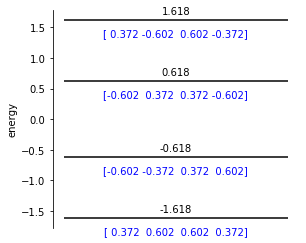

In [6]:
hueckelMatrix = linearPolyene(4)
fullRoutine(hueckelMatrix)

# example 3: Benzene

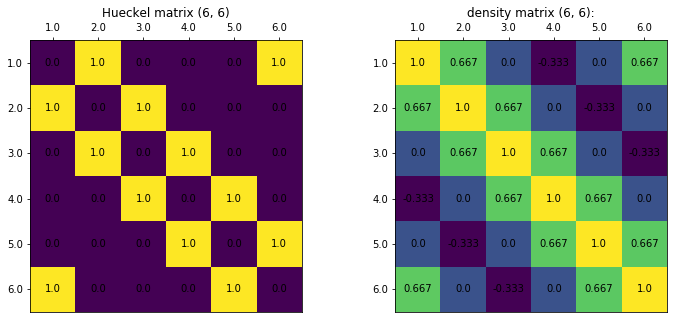


Eigenvalues and corresponding eigenvectors in ascending order (lowest energy first):
e0 = -2.00	eigenvector: [ 0.408  0.408  0.408  0.408  0.408  0.408] -> 0 nodes
e1 = -1.00	eigenvector: [-0.577 -0.289  0.289  0.577  0.289 -0.289] -> 2 nodes
e2 = -1.00	eigenvector: [ 0.000 -0.500 -0.500  0.000  0.500  0.500] -> 1 nodes
e3 =  1.00	eigenvector: [ 0.577 -0.269 -0.308  0.577 -0.269 -0.308] -> 3 nodes
e4 =  1.00	eigenvector: [ 0.023 -0.511  0.488  0.023 -0.511  0.488] -> 4 nodes
e5 =  2.00	eigenvector: [-0.408  0.408 -0.408  0.408 -0.408  0.408] -> 5 nodes

pi electron energy = -8.00
(total energy of pi electron system within Hueckel formalism)

delocalization energy = -2.00
(difference between pi electron energy of molecule with delocalized pi-bonds and
pi electron energy of hypothetical pendant with strictly localized bonds)


MO scheme (occupation = [2 2 2 0 0 0]):


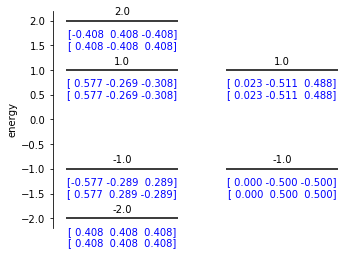

In [7]:
hueckelMatrix = cyclicPolyene(6)
fullRoutine(hueckelMatrix)

# example 4: Trimethylenmethane dication

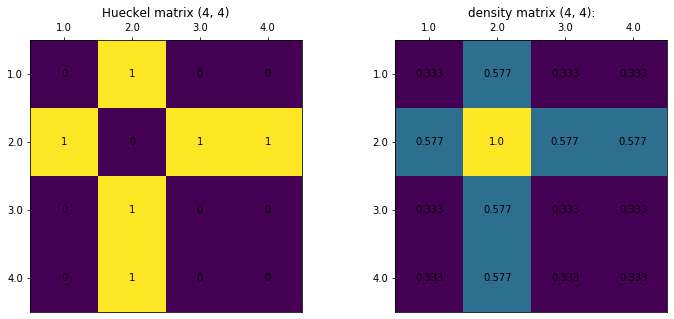


Eigenvalues and corresponding eigenvectors in ascending order (lowest energy first):
e0 = -1.73	eigenvector: [-0.408 -0.707 -0.408 -0.408] -> 0 nodes
e1 = -0.00	eigenvector: [ 0.816 -0.000 -0.408 -0.408] -> 1 nodes
e2 =  0.00	eigenvector: [ 0.000  0.000 -0.707  0.707] -> 1 nodes
e3 =  1.73	eigenvector: [ 0.408 -0.707  0.408  0.408] -> 2 nodes

pi electron energy = -3.46
(total energy of pi electron system within Hueckel formalism)

delocalization energy = -1.46
(difference between pi electron energy of molecule with delocalized pi-bonds and
pi electron energy of hypothetical pendant with strictly localized bonds)


MO scheme (occupation = [2 0 0 0]):


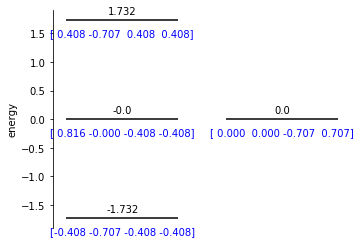

In [8]:
hueckelMatrix = trimethylenmethane_dication
fullRoutine(hueckelMatrix, 2)

# example 5: Butadienyl dication

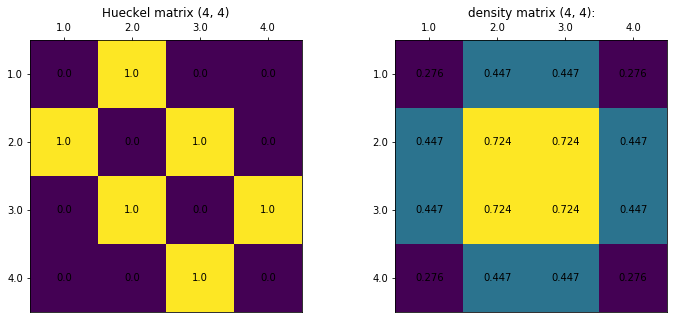


Eigenvalues and corresponding eigenvectors in ascending order (lowest energy first):
e0 = -1.62	eigenvector: [ 0.372  0.602  0.602  0.372] -> 0 nodes
e1 = -0.62	eigenvector: [-0.602 -0.372  0.372  0.602] -> 1 nodes
e2 =  0.62	eigenvector: [-0.602  0.372  0.372 -0.602] -> 2 nodes
e3 =  1.62	eigenvector: [ 0.372 -0.602  0.602 -0.372] -> 3 nodes

pi electron energy = -3.24
(total energy of pi electron system within Hueckel formalism)

delocalization energy = -1.24
(difference between pi electron energy of molecule with delocalized pi-bonds and
pi electron energy of hypothetical pendant with strictly localized bonds)


MO scheme (occupation = [2 0 0 0]):


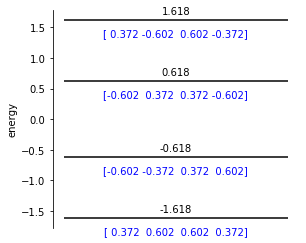

In [9]:
hueckelMatrix = linearPolyene(4)
fullRoutine(hueckelMatrix, 2)

# example 7: Allyl cation

Remember: uneven carbon numbers give radicals!


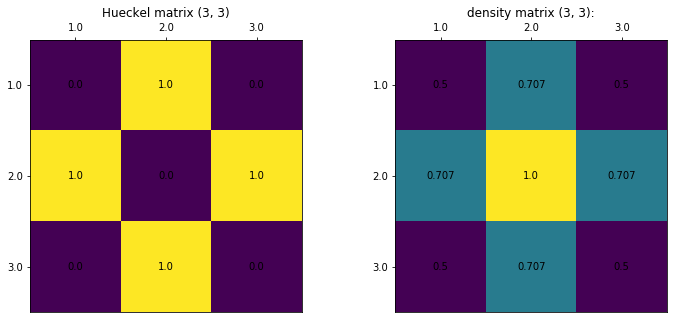


Eigenvalues and corresponding eigenvectors in ascending order (lowest energy first):
e0 = -1.41	eigenvector: [ 0.500  0.707  0.500] -> 0 nodes
e1 =  0.00	eigenvector: [-0.707  0.000  0.707] -> 1 nodes
e2 =  1.41	eigenvector: [ 0.500 -0.707  0.500] -> 2 nodes

pi electron energy = -2.83
(total energy of pi electron system within Hueckel formalism)

delocalization energy = -0.83
(difference between pi electron energy of molecule with delocalized pi-bonds and
pi electron energy of hypothetical pendant with strictly localized bonds)


MO scheme (occupation = [2 0 0]):


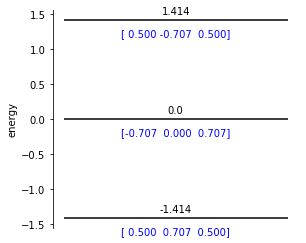

In [10]:
hueckelMatrix = linearPolyene(3)
fullRoutine(hueckelMatrix, 1)

# example 8: Allyl radical

Remember: uneven carbon numbers give radicals!


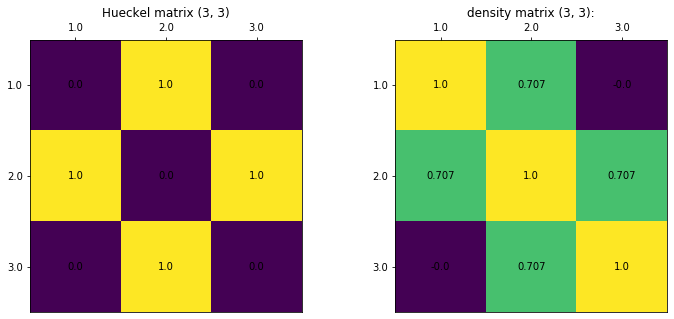


Eigenvalues and corresponding eigenvectors in ascending order (lowest energy first):
e0 = -1.41	eigenvector: [ 0.500  0.707  0.500] -> 0 nodes
e1 =  0.00	eigenvector: [-0.707  0.000  0.707] -> 1 nodes
e2 =  1.41	eigenvector: [ 0.500 -0.707  0.500] -> 2 nodes

pi electron energy = -2.83
(total energy of pi electron system within Hueckel formalism)

delocalization energy =  0.17
(difference between pi electron energy of molecule with delocalized pi-bonds and
pi electron energy of hypothetical pendant with strictly localized bonds)


MO scheme (occupation = [2 1 0]):


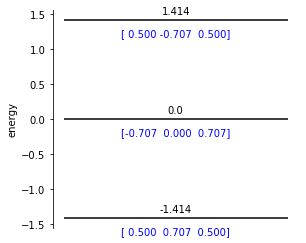

In [11]:
hueckelMatrix = linearPolyene(3)
fullRoutine(hueckelMatrix, 0)

# example 9: Allyl anion

Remember: uneven carbon numbers give radicals!


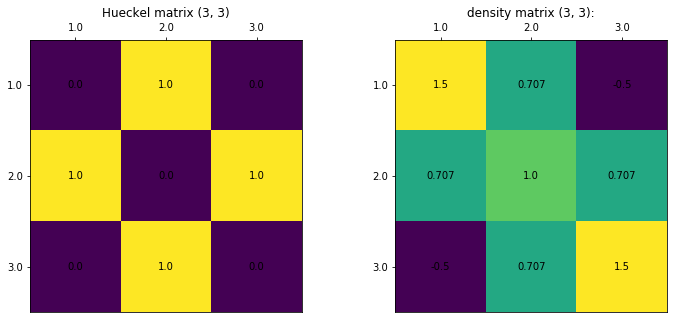


Eigenvalues and corresponding eigenvectors in ascending order (lowest energy first):
e0 = -1.41	eigenvector: [ 0.500  0.707  0.500] -> 0 nodes
e1 =  0.00	eigenvector: [-0.707  0.000  0.707] -> 1 nodes
e2 =  1.41	eigenvector: [ 0.500 -0.707  0.500] -> 2 nodes

pi electron energy = -2.83
(total energy of pi electron system within Hueckel formalism)

delocalization energy =  1.17
(difference between pi electron energy of molecule with delocalized pi-bonds and
pi electron energy of hypothetical pendant with strictly localized bonds)


MO scheme (occupation = [2 2 0]):


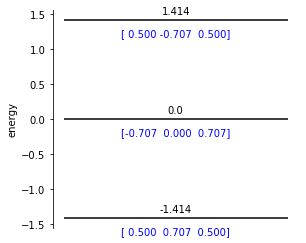

In [12]:
hueckelMatrix = linearPolyene(3)
fullRoutine(hueckelMatrix, -1)

# example 10: Calculation of HOMO-LUMO gap for linear polyenes

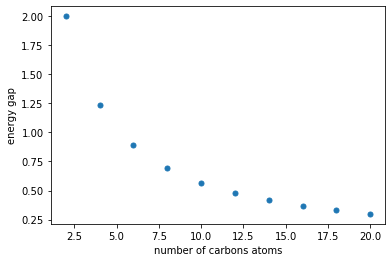

In [13]:
def getGap(energies):
    if len(energies) % 2:
        print("Uneven number of atoms. HOMO-LUMO gap calculation skipped.")
        return
    
    half = int(len(energies) * 0.5)
    return abs(energies[half] - energies[half - 1])


def gapForLinearPolyenes(n, start = 0):
    numCarbons = []
    gapEnergies = []
    
    for i in range(start, n + start):
        num = 2 * (i + 1)
        energies, eigenVectors, P, E, Ed, o = solve(linearPolyene(num))

        gapEnergies.append(getGap(energies))
        numCarbons.append(num)

    plt.plot(numCarbons, gapEnergies, ls="", marker="o", markersize="5")
    plt.xlabel("number of carbons atoms")
    plt.ylabel("energy gap")
    plt.show()


gapForLinearPolyenes(10)